In [26]:
import math
import types # Import the types module

from typing import Any, Callable, Sequence
import inspect
from langchain_core.tools import tool

# Define the function to convert positional-only functions to tools
def convert_positional_only_function_to_tool(function: Callable) -> Any:
    """
    Converts a positional-only function to a LangChain tool if possible.

    This function inspects the function's signature. If it is a built-in
    function with only positional-only arguments, it wraps it in a LangChain
    tool. Otherwise, it returns None.

    Args:
        function: The function to convert.

    Returns:
        A LangChain tool or None if the function cannot be converted.
    """
    try:
        # Inspect the function's signature
        sig = inspect.signature(function)
        parameters = sig.parameters

        # Check if all parameters are positional-only
        if all(
            param.kind == inspect.Parameter.POSITIONAL_ONLY
            for param in parameters.values()
        ):
            # Create a tool from the function
            # You might need to add a description or other metadata depending on your needs
            return tool(function)
        else:
            # Not a positional-only function, return None
            return None
    except Exception as e:
        # Handle cases where inspection might fail for certain built-ins
        print(f"Could not convert function {function.__name__}: {e}")
        return None

# Collect functions from `math` built-in
all_tools = []
for function_name in dir(math):
    function = getattr(math, function_name)
    if not isinstance(
        function, types.BuiltinFunctionType
    ):
        continue
    # This is an idiosyncrasy of the `math` library
    if tool := convert_positional_only_function_to_tool(
        function
    ):
        all_tools.append(tool)

Could not convert function acosh: 'StructuredTool' object is not callable
Could not convert function asin: 'NoneType' object is not callable
Could not convert function asinh: 'NoneType' object is not callable
Could not convert function atan: 'NoneType' object is not callable
Could not convert function atan2: 'NoneType' object is not callable
Could not convert function atanh: 'NoneType' object is not callable
Could not convert function cbrt: 'NoneType' object is not callable
Could not convert function ceil: 'NoneType' object is not callable
Could not convert function comb: 'NoneType' object is not callable
Could not convert function copysign: 'NoneType' object is not callable
Could not convert function cos: 'NoneType' object is not callable
Could not convert function cosh: 'NoneType' object is not callable
Could not convert function degrees: 'NoneType' object is not callable
Could not convert function dist: 'NoneType' object is not callable
Could not convert function erf: 'NoneType' obj

# Agents

In [2]:
from typing import TypedDict  # For defining the state schema with type hints

from rich.console import Console  # For pretty-printing output
from rich.pretty import pprint  # For pretty-printing Python objects

# Initialize a console for rich, formatted output in the notebook.
console = Console()

In [3]:
# Define the schema for the graph's state using TypedDict.
# This class acts as a data structure that will be passed between nodes in the graph.
# It ensures that the state has a consistent shape and provides type hints.
class State(TypedDict):
    """
    Defines the structure of the state for our joke generator workflow.

    Attributes:
        topic: The input topic for which a joke will be generated.
        joke: The output field where the generated joke will be stored.
    """
    topic: str
    joke: str

In [4]:
%pip install langgraph
%pip install langchain-anthropic
%pip install langchain-openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.2/471.2 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.3/208.3 kB 14.3 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.79
    Uninstalling langchain-core-0.3.79:
      Successfully uninstalled langchain-core-0.3.79
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain 0.3.27 requires langchain-core<1.0.0,>=0.3.72, but you have langchain-core 1.0.4 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.

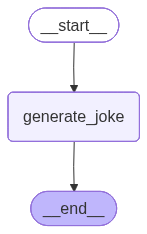

In [5]:
# Import necessary libraries for environment management, display, and LangGraph
import getpass
import os

from IPython.display import Image, display
# from langchain.chat_models import init_chat_model # Remove this import
from langchain_openai import ChatOpenAI # Import ChatOpenAI
from langgraph.graph import END, START, StateGraph

from google.colab import userdata
# --- Environment and Model Setup ---
# Set the OpenAI API key to authenticate requests
api_key = userdata.get("OPENAI_API_KEY")
if not api_key:
    raise ValueError("Missing OPENAI_API_KEY in environment")

os.environ["OPENAI_API_KEY"] = api_key

# Initialize the chat model to be used in the workflow
# We use a specific OpenAI model with temperature=0 for deterministic outputs
llm = ChatOpenAI(model="gpt-4o", temperature=0) # Use ChatOpenAI instead of init_chat_model

# --- Define Workflow Node ---
def generate_joke(state: State) -> dict[str, str]:
    """
    A node function that generates a joke based on the topic in the current state.

    This function reads the 'topic' from the state, uses the LLM to generate a joke,
    and returns a dictionary to update the 'joke' field in the state.

    Args:
        state: The current state of the graph, which must contain a 'topic'.

    Returns:
        A dictionary with the 'joke' key to update the state.
    """
    # Read the topic from the state
    topic = state["topic"]
    print(f"Generating a joke about: {topic}")

    # Invoke the language model to generate a joke
    msg = llm.invoke(f"Write a short joke about {topic}")

    # Return the generated joke to be written back to the state
    return {"joke": msg.content}

# --- Build and Compile the Graph ---
# Initialize a new StateGraph with the predefined State schema
workflow = StateGraph(State)

# Add the 'generate_joke' function as a node in the graph
workflow.add_node("generate_joke", generate_joke)

# Define the workflow's execution path:
# The graph starts at the START entrypoint and flows to our 'generate_joke' node.
workflow.add_edge(START, "generate_joke")
# After 'generate_joke' completes, the graph execution ends.
workflow.add_edge("generate_joke", END)

# Compile the workflow into an executable chain
chain = workflow.compile()

# --- Visualize the Graph ---
# Display a visual representation of the compiled workflow graph
display(Image(chain.get_graph().draw_mermaid_png()))

In [6]:
# --- Execute the Workflow ---
# Invoke the compiled graph with an initial state containing the topic.
# The `invoke` method runs the graph from the START node to the END node.
joke_generator_state = chain.invoke({"topic": "cats"})

# --- Display the Final State ---
# Print the final state of the graph after execution.
# This will show both the input 'topic' and the output 'joke' that was written to the state.
console.print("\n[bold blue]Joke Generator State:[/bold blue]")
pprint(joke_generator_state)



#### OUTPUT ####
{
  'topic': 'cats',
  'joke': 'Why did the cat join a band?\n\nBecause it wanted to be the purr-cussionist!'
}

Generating a joke about: cats


Joke Generator State:

{
│   'topic': 'cats',
│   'joke': 'Why was the cat sitting on the computer? \n\nBecause it wanted to keep an eye on the mouse!'
}

{'topic': 'cats',
 'joke': 'Why did the cat join a band?\n\nBecause it wanted to be the purr-cussionist!'}

# Memory Writing in LangGraph

In [8]:
from langgraph.store.memory import InMemoryStore

# --- Initialize Long-Term Memory Store ---
# Create an instance of InMemoryStore, which provides a simple, non-persistent,
# key-value storage system for use within the current session.
store = InMemoryStore()

# --- Define a Namespace for Organization ---
# A namespace is used to logically group related data within the store.
# Here, we use a tuple to represent a hierarchical namespace,
# which could correspond to a user ID and an application context.
namespace = ("rlm", "joke_generator")

# --- Write Data to the Memory Store ---
# Use the `put` method to save a key-value pair into the specified namespace.
# This operation persists the joke generated in the previous step, making it
# available for retrieval across different sessions or threads.
store.put(namespace, "last_joke", {"joke": joke_generator_state["joke"]})

#

In [9]:
# Search the namespace to view all stored items
stored_items = list(store.search(namespace))

# Display the stored items with rich formatting
console.print("\n[bold green]Stored Items in Memory:[/bold green]")
pprint(stored_items)

Stored Items in Memory:

[
│   Item(namespace=['rlm', 'joke_generator'], key='last_joke', value={'joke': 'Why was the cat sitting on the computer? \n\nBecause it wanted to keep an eye on the mouse!'}, created_at='2025-11-08T13:15:58.091218+00:00', updated_at='2025-11-08T13:15:58.091224+00:00', score=None)
]

In [10]:
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.store.base import BaseStore
from langgraph.store.memory import InMemoryStore

# Initialize storage components
checkpointer = InMemorySaver()  # For thread-level state persistence
memory_store = InMemoryStore()  # For cross-thread memory storage


def generate_joke(state: State, store: BaseStore) -> dict[str, str]:
    """Generate a joke with memory awareness.

    This enhanced version checks for existing jokes in memory
    before generating new ones.

    Args:
        state: Current state containing the topic
        store: Memory store for persistent context

    Returns:
        Dictionary with the generated joke
    """
    # Check if there's an existing joke in memory
    existing_jokes = list(store.search(namespace))
    if existing_jokes:
        existing_joke = existing_jokes[0].value
        print(f"Existing joke: {existing_joke}")
    else:
        print("Existing joke: No existing joke")

    # Generate a new joke based on the topic
    msg = llm.invoke(f"Write a short joke about {state['topic']}")

    # Store the new joke in long-term memory
    store.put(namespace, "last_joke", {"joke": msg.content})

    # Return the joke to be added to state
    return {"joke": msg.content}


# Build the workflow with memory capabilities
workflow = StateGraph(State)

# Add the memory-aware joke generation node
workflow.add_node("generate_joke", generate_joke)

# Connect the workflow components
workflow.add_edge(START, "generate_joke")
workflow.add_edge("generate_joke", END)

# Compile with both checkpointing and memory store
chain = workflow.compile(checkpointer=checkpointer, store=memory_store)

In [11]:
# Execute the workflow with thread-based configuration
config = {"configurable": {"thread_id": "1"}}
joke_generator_state = chain.invoke({"topic": "cats"}, config)

Existing joke: No existing joke


In [12]:
# Display the workflow result with rich formatting
console.print("\n[bold cyan]Workflow Result (Thread 1):[/bold cyan]")
pprint(joke_generator_state)

#### OUTPUT ####

Workflow Result (Thread 1):

{
│   'topic': 'cats',
│   'joke': 'Why was the cat sitting on the computer? \n\nBecause it wanted to keep an eye on the mouse!'
}

In [13]:
# --- Retrieve and Inspect the Graph State ---
# Use the `get_state` method to retrieve the latest state snapshot for the
# thread specified in the `config` (in this case, thread "1"). This is
# possible because we compiled the graph with a checkpointer.
latest_state = chain.get_state(config)

# --- Display the State Snapshot ---
# Print the retrieved state to the console. The StateSnapshot includes not only
# the data ('topic', 'joke') but also execution metadata.
console.print("\n[bold magenta]Latest Graph State (Thread 1):[/bold magenta]")
pprint(latest_state)

# Execute the workflow with a different thread ID
config = {"configurable": {"thread_id": "2"}}
joke_generator_state = chain.invoke({"topic": "cats"}, config)

# Display the result showing memory persistence across threads
console.print("\n[bold yellow]Workflow Result (Thread 2):[/bold yellow]")
pprint(joke_generator_state)

#### OUTPUT ####

Latest Graph State (Thread 1):

StateSnapshot(
│   values={
│   │   'topic': 'cats',
│   │   'joke': 'Why was the cat sitting on the computer? \n\nBecause it wanted to keep an eye on the mouse!'
│   },
│   next=(),
│   config={
│   │   'configurable': {
│   │   │   'thread_id': '1',
│   │   │   'checkpoint_ns': '',
│   │   │   'checkpoint_id': '1f0bca51-43a7-6db1-8001-4a941d73a03d'
│   │   }
│   },
│   metadata={'source': 'loop', 'step': 1, 'parents': {}},
│   created_at='2025-11-08T13:16:04.348837+00:00',
│   parent_config={
│   │   'configurable': {
│   │   │   'thread_id': '1',
│   │   │   'checkpoint_ns': '',
│   │   │   'checkpoint_id': '1f0bca51-360b-6035-8000-ce46b29f031d'
│   │   }
│   },
│   tasks=(),
│   interrupts=()
)

Existing joke: {'joke': 'Why was the cat sitting on the computer? \n\nBecause it wanted to keep an eye on the mouse!'}


Workflow Result (Thread 2):

{
│   'topic': 'cats',
│   'joke': 'Why was the cat sitting on the computer?\n\nBecause it wanted to keep an eye on the mouse!'
}

In [14]:
def generate_joke(state: State) -> dict[str, str]:
    """Generate an initial joke about the topic.

    Args:
        state: Current state containing the topic

    Returns:
        Dictionary with the generated joke
    """
    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}


def improve_joke(state: State) -> dict[str, str]:
    """Improve an existing joke by adding wordplay.

    This demonstrates selecting context from state - we read the existing
    joke from state and use it to generate an improved version.

    Args:
        state: Current state containing the original joke

    Returns:
        Dictionary with the improved joke
    """
    print(f"Initial joke: {state['joke']}")

    # Select the joke from state to present it to the LLM
    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}

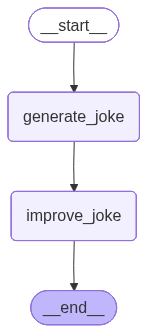

In [15]:
# Build the workflow with two sequential nodes
workflow = StateGraph(State)

# Add both joke generation nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)

# Connect nodes in sequence
workflow.add_edge(START, "generate_joke")
workflow.add_edge("generate_joke", "improve_joke")
workflow.add_edge("improve_joke", END)

# Compile the workflow
chain = workflow.compile()

# Display the workflow visualization
display(Image(chain.get_graph().draw_mermaid_png()))

In [16]:
# Execute the workflow to see context selection in action
joke_generator_state = chain.invoke({"topic": "cats"})

# Display the final state with rich formatting
console.print("\n[bold blue]Final Workflow State:[/bold blue]")
pprint(joke_generator_state)

#### OUTPUT ####

Initial joke: Why was the cat sitting on the computer? 

Because it wanted to keep an eye on the mouse!


Final Workflow State:

{
│   'topic': 'cats',
│   'joke': 'Why was the cat sitting on the computer? \n\nBecause it wanted to keep an eye on the mouse!'
}

# Memory Selection Ability

In [17]:
from langgraph.store.memory import InMemoryStore

from langgraph.store.memory import InMemoryStore
store = InMemoryStore()

# Define namespace for organizing memories
namespace = ("rlm", "joke_jenerator")

# Store the generated joke in memory
store.put(
    namespace,
    "last_joke",  # Store the generated joke in memory
     {"joke": joke_generator_state["joke"]} # value to store
    )

# Select (retrieve) the joke from memory
retrieved_joke = store.get(namespace, "last_joke").value

# Display the retrieved context
console.print("\n[bold green]Retrieved Context from Memory:[/bold green]")
pprint(retrieved_joke)

#### OUTPUT ####

Retrieved Context from Memory:

{'joke': 'Why was the cat sitting on the computer? \n\nBecause it wanted to keep an eye on the mouse!'}

In [18]:
# Initialize storage components
checkpointer = InMemorySaver()
memory_store = InMemoryStore()


def generate_joke(state: State, store: BaseStore) -> dict[str, str]:
    """Generate a joke with memory-aware context selection.

    This function demonstrates selecting context from memory before
    generating new content, ensuring consistency and avoiding duplication.

    Args:
        state: Current state containing the topic
        store: Memory store for persistent context

    Returns:
        Dictionary with the generated joke
    """
    # Select prior joke from memory if it exists
    prior_joke = store.get(namespace, "last_joke")
    if prior_joke:
        prior_joke_text = prior_joke.value["joke"]
        print(f"Prior joke: {prior_joke_text}")
    else:
        print("Prior joke: None!")

    # Generate a new joke that differs from the prior one
    prompt = (
        f"Write a short joke about {state['topic']}, "
        f"but make it different from any prior joke you've written: {prior_joke_text if prior_joke else 'None'}"
    )
    msg = llm.invoke(prompt)

    # Store the new joke in memory for future context selection
    store.put(namespace, "last_joke", {"joke": msg.content})

    return {"joke": msg.content}

In [19]:
# Build the memory-aware workflow
workflow = StateGraph(State)
workflow.add_node("generate_joke", generate_joke)

# Connect the workflow
workflow.add_edge(START, "generate_joke")
workflow.add_edge("generate_joke", END)

# Compile with both checkpointing and memory store
chain = workflow.compile(checkpointer=checkpointer, store=memory_store)

# Execute the workflow with the first thread
config = {"configurable": {"thread_id": "1"}}
joke_generator_state = chain.invoke({"topic": "cats"}, config)

#### OUTPUT ####

Prior joke: None!


In [20]:
# Get the latest state of the graph
latest_state = chain.get_state(config)

console.print("\n[bold magenta]Latest Graph State:[/bold magenta]")
pprint(latest_state)

Latest Graph State:

StateSnapshot(
│   values={
│   │   'topic': 'cats',
│   │   'joke': 'Why did the cat sit on the computer? Because it wanted to keep an eye on the mouse!'
│   },
│   next=(),
│   config={
│   │   'configurable': {
│   │   │   'thread_id': '1',
│   │   │   'checkpoint_ns': '',
│   │   │   'checkpoint_id': '1f0bca52-b562-64db-8001-0adda6651751'
│   │   }
│   },
│   metadata={'source': 'loop', 'step': 1, 'parents': {}},
│   created_at='2025-11-08T13:16:43.117657+00:00',
│   parent_config={
│   │   'configurable': {
│   │   │   'thread_id': '1',
│   │   │   'checkpoint_ns': '',
│   │   │   'checkpoint_id': '1f0bca52-aebe-68de-8000-b3a4ae336bc1'
│   │   }
│   },
│   tasks=(),
│   interrupts=()
)

In [21]:
# Execute the workflow with a second thread to demonstrate memory persistence
config = {"configurable": {"thread_id": "2"}}
joke_generator_state = chain.invoke({"topic": "cats"}, config)

#### OUTPUT ####

Prior joke: Why did the cat sit on the computer? Because it wanted to keep an eye on the mouse!


# Advantage of LangGraph BigTool Calling

In [49]:
!pip install langgraph-bigtool
!pip install langchain-core

In [50]:
!pip install langgraph-bigtool "langchain[openai]"

INFO: pip is looking at multiple versions of langchain-openai to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of langgraph-prebuilt to determine which version is compatible with other requirements. This could take a while.
  Using cached langgraph_checkpoint-3.0.1-py3-none-any.whl.metadata (4.7 kB)
INFO: pip is still looking at multiple versions of langgraph-prebuilt to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of langchain-openai to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
INFO: This is taking longer than usual. You might nee

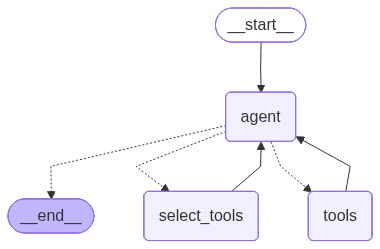

In [3]:
import math
import types
import uuid
import os

from langchain.chat_models import init_chat_model
from langchain.embeddings import init_embeddings
from langgraph.store.memory import InMemoryStore

from langgraph_bigtool import create_agent
from langgraph_bigtool.utils import (
    convert_positional_only_function_to_tool
)

from google.colab import userdata
# ANTHROPIC_API_KEY = userdata.get('ANTHROPIC_API_KEY')

# --- Environment and Model Setup ---
# Set the OpenAI API key to authenticate requests
api_key = userdata.get("OPENAI_API_KEY")
if not api_key:
    raise ValueError("Missing OPENAI_API_KEY in environment")

os.environ["OPENAI_API_KEY"] = api_key

# Collect functions from `math` built-in
all_tools = []
for function_name in dir(math):
    function = getattr(math, function_name)
    if not isinstance(
        function, types.BuiltinFunctionType
    ):
        continue
    # This is an idiosyncrasy of the `math` library
    if tool := convert_positional_only_function_to_tool(
        function
    ):
        all_tools.append(tool)

# Create registry of tools. This is a dict mapping
# identifiers to tool instances.
tool_registry = {
    str(uuid.uuid4()): tool
    for tool in all_tools
}

# Index tool names and descriptions in the LangGraph
# Store. Here we use a simple in-memory store.
embeddings = init_embeddings("openai:text-embedding-3-small")

store = InMemoryStore(
    index={
        "embed": embeddings,
        "dims": 1536,
        "fields": ["description"],
    }
)
for tool_id, tool in tool_registry.items():
    store.put(
        ("tools",),
        tool_id,
        {
            "description": f"{tool.name}: {tool.description}",
        },
    )

# Initialize agent
llm = init_chat_model("openai:gpt-4o-mini")

builder = create_agent(llm, tool_registry)
agent = builder.compile(store=store)
agent

In [4]:
query = "Use available tools to calculate arc cosine of 0.5."

# Test it out
for step in agent.stream(
    {"messages": query},
    stream_mode="updates",
):
    for _, update in step.items():
        for message in update.get("messages", []):
            message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  retrieve_tools (call_kO3OPtETJxRzJvG4Tgi1X1FY)
 Call ID: call_kO3OPtETJxRzJvG4Tgi1X1FY
  Args:
    query: calculate arc cosine of 0.5
================================= Tool Message =================================

Available tools: ['acos', 'asin']
================================== Ai Message ==================================
Tool Calls:
  acos (call_y7w3dsRpU5hwNeWEIMoBX3EC)
 Call ID: call_y7w3dsRpU5hwNeWEIMoBX3EC
  Args:
    x: 0.5
================================= Tool Message =================================
Name: acos

1.0471975511965979
================================== Ai Message ==================================

The arc cosine of 0.5 is approximately 1.0472 radians.


# RAG with Contextual Engineering

In [6]:
!pip install langchain-community

  Using cached langchain_core-1.0.4-py3-none-any.whl.metadata (3.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 48.6 MB/s eta 0:00:00
Using cached langchain_core-1.0.4-py3-none-any.whl (471 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.6 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.79
    Uninstalling langchain-core-0.3.79:
      Successfully uninstalled langchain-core-0.3.79
  Attempting uninstall: langchain-text-splitters
    Found existing installation: langchain-text-splitters 0.3.11
    Uninstalling langchain-text-splitters-0.3.11:
      Successfully uninstalled langchain-text

In [43]:
# Import the WebBaseLoader to fetch documents from URLs
from langchain_community.document_loaders import WebBaseLoader

# Define the list of URLs for Lilian Weng's blog posts
urls = [
    "https://lilianweng.github.io/posts/2025-05-01-thinking/",
    "https://lilianweng.github.io/posts/2024-11-28-reward-hacking/",
    "https://lilianweng.github.io/posts/2024-07-07-hallucination/",
    "https://lilianweng.github.io/posts/2024-04-12-diffusion-video/",
]

# Load the documents from the specified URLs using a list comprehension.
# This creates a WebBaseLoader for each URL and calls its load() method.
docs = [WebBaseLoader(url).load() for url in urls]

In [44]:
# Import the text splitter for chunking documents
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Flatten the list of documents. WebBaseLoader returns a list of documents for each URL,
# so we have a list of lists. This comprehension combines them into a single list.
docs_list = [item for sublist in docs for item in sublist]

# Initialize the text splitter. This will split the documents into smaller chunks
# of a specified size, with some overlap between chunks to maintain context.
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=2000, chunk_overlap=50
)

# Split the documents into chunks.
doc_splits = text_splitter.split_documents(docs_list)

In [45]:
# Import the necessary class for creating an in-memory vector store
from langchain_core.vectorstores import InMemoryVectorStore


from google.colab import userdata
# --- Environment and Model Setup ---
# Set the OpenAI API key to authenticate requests
api_key = userdata.get("OPENAI_API_KEY")
if not api_key:
    raise ValueError("Missing OPENAI_API_KEY in environment")

from langchain_openai import OpenAIEmbeddings # Import OpenAIEmbeddings directly
# Index tool names and descriptions in the LangGraph
# Store. Here we use a simple in-memory store.
embeddings = OpenAIEmbeddings(model="text-embedding-3-small", api_key=api_key) # Pass the api_key explicitly


# Create an in-memory vector store from the document splits.
# This uses the 'doc_splits' created in the previous cell and the 'embeddings' model
# initialized earlier to create vector representations of the text chunks.
vectorstore = InMemoryVectorStore.from_documents(
    documents=doc_splits, embedding=embeddings
)

# Create a retriever from the vector store.
# The retriever provides an interface to search for relevant documents
# based on a query.
retriever = vectorstore.as_retriever()

In [46]:
# Import the function to create a retriever tool
from langchain.tools.retriever import create_retriever_tool

# Create a retriever tool from the vector store retriever.
# This tool allows the agent to search for and retrieve relevant
# documents from the blog posts based on a query.
retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts.",
)

# The following line is an example of how to invoke the tool directly.
# It's commented out as it's not needed for the agent execution flow but can be useful for testing.
# retriever_tool.invoke({"query": "types of reward hacking"})

In [47]:
from google.colab import userdata
# --- Environment and Model Setup ---
# Set the OpenAI API key to authenticate requests
api_key = userdata.get("OPENAI_API_KEY")
if not api_key:
    raise ValueError("Missing OPENAI_API_KEY in environment")

from langchain_openai import ChatOpenAI # Import ChatOpenAI
# Initialize the chat model to be used in the workflow
# We use a specific OpenAI model with temperature=0 for deterministic outputs
llm = ChatOpenAI(model="gpt-4o", temperature=0, api_key=api_key) # Pass the api_key explicitly


# Augment the LLM with tools
tools = [retriever_tool]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

In [48]:
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage, ToolMessage
from typing_extensions import Literal

rag_prompt = """You are a helpful assistant tasked with retrieving information from a series of technical blog posts by Lilian Weng.
Clarify the scope of research with the user before using your retrieval tool to gather context. Reflect on any context you fetch, and
proceed until you have sufficient context to answer the user's research request."""

In [49]:
# --- Define Agent Nodes ---

def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or generate a final answer."""
    # Add the system prompt to the current message state
    messages_with_prompt = [SystemMessage(content=rag_prompt)] + state["messages"]

    # Invoke the LLM with the augmented message list
    response = llm_with_tools.invoke(messages_with_prompt)

    # Return the LLM's response to be added to the state
    return {"messages": [response]}

def tool_node(state: dict):
    """Performs the tool call and returns the observation."""
    # Get the last message, which should contain the tool calls
    last_message = state["messages"][-1]

    # Execute each tool call and collect the results
    result = []
    for tool_call in last_message.tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=str(observation), tool_call_id=tool_call["id"]))

    # Return the tool's output as a message
    return {"messages": result}

In [50]:
# --- Define Conditional Edge ---
from langgraph.graph import END, START, StateGraph

def should_continue(state: MessagesState) -> Literal["Action", END]:
    """Decides the next step based on whether the LLM made a tool call."""
    last_message = state["messages"][-1]

    # If the LLM made a tool call, route to the tool_node
    if last_message.tool_calls:
        return "Action"
    # Otherwise, end the workflow
    return END

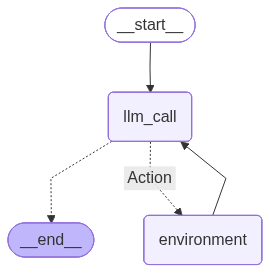

In [51]:

# Build workflow
from langgraph.graph import END, START, StateGraph
from IPython.display import Image, display # Import Image and display

agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "Action": "environment",
        END: END,
    }
)
agent_builder.add_edge("environment", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [54]:
!pip install utils

In [59]:
# Import a utility function to format and display messages
# from utils import format_messages

# Define the user's query
query = "What are the types of reward hacking discussed in the blogs?"

# Invoke the agent with the query
result = agent.invoke({"messages": [("user", query)]})

# --- Display the Final Messages ---
# Format and print the conversation flow
print(result['messages'])

[HumanMessage(content='What are the types of reward hacking discussed in the blogs?', additional_kwargs={}, response_metadata={}, id='a5c3f2c5-0eee-4fdf-a628-e202b1a6810c'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_9PKI8p1tXA9P8YFN936MDup4', 'function': {'arguments': '{"query":"reward hacking"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 135, 'total_tokens': 151, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CZfEFHoVYZXWcyMYxsulyl8tRgP1a', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--dcd861f4-023e-4935-8cf6-e54289b68b5a-0', tool_calls=[{'name': 'retrieve_blog_posts

# Compression Strategy with knowledgeable Agents

In [63]:
# Define extended state with a summary field
class State(MessagesState):
    """Extended state that includes a summary field for context compression."""
    summary: str

# Define the summarization prompt
summarization_prompt = """Summarize the full chat history and all tool feedback to
give an overview of what the user asked about and what the agent did."""

def summary_node(state: MessagesState) -> dict:
    """
    Generate a summary of the conversation and tool interactions.

    Args:
        state: The current state of the graph, containing the message history.

    Returns:
        A dictionary with the key "summary" and the generated summary string
        as the value, which updates the state.
    """
    # Prepend the summarization system prompt to the message history
    messages = [SystemMessage(content=summarization_prompt)] + state["messages"]

    # Invoke the language model to generate the summary
    result = llm.invoke(messages)

    # Return the summary to be stored in the 'summary' field of the state
    return {"summary": result.content}

def should_continue(state: MessagesState) -> Literal["Action", "summary_node"]:
    """Determine next step based on whether LLM made tool calls."""
    last_message = state["messages"][-1]

    # If LLM made tool calls, execute them
    if last_message.tool_calls:
        return "Action"
    # Otherwise, proceed to summarization
    return "summary_node"

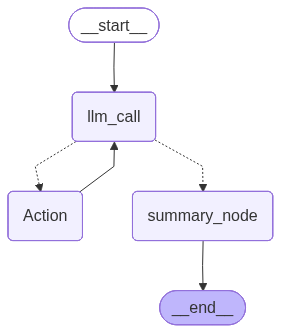

In [64]:
# Build the RAG agent workflow
agent_builder = StateGraph(State)

# Add nodes to the workflow
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("Action", tool_node)
agent_builder.add_node("summary_node", summary_node)

# Define the workflow edges
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        "Action": "Action",
        "summary_node": "summary_node",
    },
)
agent_builder.add_edge("Action", "llm_call")
agent_builder.add_edge("summary_node", END)

# Compile the agent
agent = agent_builder.compile()

# Display the agent workflow
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [66]:
# Now, let’s run it with a query that will require fetching a lot of context.


from rich.markdown import Markdown

query = "Why does RL improve LLM reasoning according to the blogs?"
result = agent.invoke({"messages": [("user", query)]})

# Print the final message to the user
# format_message(result['messages'][-1]) # Remove this line
print(result['messages'][-1].content) # Replace with a print statement

# Print the generated summary
# Markdown(result["summary"]) # This line doesn't display the markdown in Colab
print("\nSummary:") # Add a label for the summary
print(result["summary"]) # Print the summary content

Reinforcement Learning (RL) improves the reasoning abilities of Large Language Models (LLMs) by using a collection of questions with ground truth answers, often from STEM problems and puzzles that have easily verifiable answers. The process involves rewarding the model for arriving at the correct answer, which enhances its reasoning capabilities. This approach has been particularly successful in recent models, such as those from OpenAI's o-series and DeepSeek.

For instance, DeepSeek-R1, an open-source LLM, is designed to excel in tasks requiring advanced reasoning skills like math, coding, and logical problem-solving. It undergoes two rounds of Supervised Fine-Tuning (SFT) and RL training, which enables it to perform well in both reasoning and non-reasoning tasks. The RL training focuses on reasoning-oriented tasks with rule-based rewards, such as format rewards (ensuring the model wraps its chain-of-thoughts in specific tokens) and accuracy rewards (verifying the correctness of final

In [67]:
tool_summarization_prompt = """You will be provided a doc from a RAG system.
Summarize the docs, ensuring to retain all relevant / essential information.
Your goal is simply to reduce the size of the doc (tokens) to a more manageable size."""


In [68]:
def tool_node_with_summarization(state: dict):
    """Performs the tool call and then summarizes the output."""
    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])

        # Summarize the doc
        summary_msg = llm.invoke([
            SystemMessage(content=tool_summarization_prompt),
            ("user", str(observation))
        ])

        result.append(ToolMessage(content=summary_msg.content, tool_call_id=tool_call["id"]))
    return {"messages": result}

In [69]:
def should_continue(state: MessagesState) -> Literal["Action", END]:
    """Decide if we should continue the loop or stop."""
    if state["messages"][-1].tool_calls:
        return "Action"
    return END

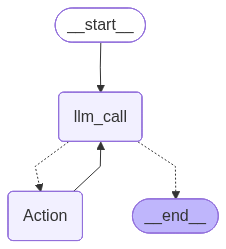

In [70]:
# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("Action", tool_node_with_summarization)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        "Action": "Action",
        END: END,
    },
)
agent_builder.add_edge("Action", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [72]:
query = "Why does RL improve LLM reasoning according to the blogs?"
result = agent.invoke({"messages": [("user", query)]})
print(result['messages'])

[HumanMessage(content='Why does RL improve LLM reasoning according to the blogs?', additional_kwargs={}, response_metadata={}, id='aa3e3e61-e87d-4279-aa44-8047e7ed5f5f'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_1riI7dY5OUYtgzs3v5BKcwhc', 'function': {'arguments': '{"query":"RL improve LLM reasoning"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 135, 'total_tokens': 154, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CZfN7Ry9g7XbWEAeJnwQOsPjhhXDp', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--da202763-6f30-49ec-87dd-56db2ccd7c7c-0', tool_calls=[{'name': 'retrieve_blo

# Isolating Context using Sub-Agents Architecture

In [74]:
!pip install langgraph_supervisor

In [78]:
from langgraph.prebuilt import create_react_agent
from langgraph_supervisor import create_supervisor

# --- Define Tools for Each Agent ---
def add(a: float, b: float) -> float:
    """Add two numbers."""
    return a + b

def multiply(a: float, b: float) -> float:
    """Multiply two numbers."""
    return a * b

def web_search(query: str) -> str:
    """Mock web search function that returns FAANG company headcounts."""
    return (
        "Here are the headcounts for each of the FAANG companies in 2024:\n"
        "1. **Facebook (Meta)**: 67,317 employees.\n"
        "2. **Apple**: 164,000 employees.\n"
        "3. **Amazon**: 1,551,000 employees.\n"
        "4. **Netflix**: 14,000 employees.\n"
        "5. **Google (Alphabet)**: 181,269 employees."
    )

In [80]:
# --- Create Specialized Agents with Isolated Contexts ---
math_agent = create_react_agent(
    model=llm,
    tools=[add, multiply],
    name="math_expert",
    prompt="You are a math expert. Always use one tool at a time."
)

research_agent = create_react_agent(
    model=llm,
    tools=[web_search],
    name="research_expert",
    prompt="You are a world class researcher with access to web search. Do not do any math."
)

# --- Create Supervisor Workflow for Coordinating Agents ---
workflow = create_supervisor(
    [research_agent, math_agent],
    model=llm,
    prompt=(
        "You are a team supervisor managing a research expert and a math expert. "
        "Delegate tasks to the appropriate agent to answer the user's query. "
        "For current events or facts, use research_agent. "
        "For math problems, use math_agent."
    )
)

# Compile the multi-agent application
app = workflow.compile()


/tmp/ipython-input-199748465.py:2: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  math_agent = create_react_agent(
/tmp/ipython-input-199748465.py:9: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  research_agent = create_react_agent(


In [82]:
# --- Execute the Multi-Agent Workflow ---
result = app.invoke({
    "messages": [
        {
            "role": "user",
            "content": "what's the combined headcount of the FAANG companies in 2024?"
        }
    ]
})

# Format and display the results
print(result['messages'])

[HumanMessage(content="what's the combined headcount of the FAANG companies in 2024?", additional_kwargs={}, response_metadata={}, id='7fa66dc4-9fc1-4e15-af46-67564dc80340'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_i4v5lw4dwCYL14GKG8SmYC8N', 'function': {'arguments': '{}', 'name': 'transfer_to_research_expert'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 126, 'total_tokens': 140, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CZfUXJDttYLMnirFORoSaD2R3tP7S', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, name='supervisor', id='lc_run--edb44b5f-6a9a-4250-83c9-3eb20a8844f8-0', tool_calls=[{'name': 'transfer_to_res